In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


crimes = pd.read_csv("crimes.csv", parse_dates=["Date Rptd", "DATE OCC"], dtype={"TIME OCC": str}) # I reviewed the dataset prior to reading it

In [3]:
# Exploratory analysis

print(crimes.isna().sum())
print(crimes.info())
print(crimes["Status Desc"].value_counts())
print(crimes["Crm Cd Desc"].value_counts())
print(crimes[crimes["TIME OCC"].str.contains("^00")]["TIME OCC"].head())

DR_NO                0
Date Rptd            0
DATE OCC             0
TIME OCC             0
AREA NAME            0
Crm Cd Desc          0
Vict Age             0
Vict Sex            11
Vict Descent        10
Weapon Desc     112213
Status Desc          0
LOCATION             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185715 entries, 0 to 185714
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DR_NO         185715 non-null  int64         
 1   Date Rptd     185715 non-null  datetime64[ns]
 2   DATE OCC      185715 non-null  datetime64[ns]
 3   TIME OCC      185715 non-null  object        
 4   AREA NAME     185715 non-null  object        
 5   Crm Cd Desc   185715 non-null  object        
 6   Vict Age      185715 non-null  int64         
 7   Vict Sex      185704 non-null  object        
 8   Vict Descent  185705 non-null  object        
 9   Weapon Desc   73502 non-null   obj

In [4]:
# Add a column of hours to the data frame
crimes["hours"] = [int(x[:2]) for x in crimes["TIME OCC"]]

In [5]:
# Define a function that counts the number of crimes per another variable - function

def grouping (df,col1,col2,method):
    """ Groups crimes on the basis of the desired column """
    grouped_df = df.groupby(col1).agg(crimes_per_grouped = (col2,method))
    
    def max_val():
        """ Calculates the max value and the matching index for the dataframe"""
        max_value = grouped_df["crimes_per_grouped"].max()
        corresponding_max_val = grouped_df["crimes_per_grouped"].idxmax()
        return max_value, corresponding_max_val
    
    return grouped_df,max_val()

In [35]:
# Define a function to make the visualizations

def plot_data(ax, plot_func, x, y, color, xlabel, ylabel,title, **kwargs):
    """ Generalized plotting function using Seaborn """
    plot_func(x= x, y= y, ax= ax, color= color, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, color='black')
    ax.set_title(title, y=1.02)
    plt.xlim(0,None)


In [36]:
# Question 1 - calculate the hour with the highest crime rate

crimes_hours,(max_crime_rate,max_hour) = grouping(crimes,"hours","DR_NO","count")
peak_crime_hour = max_hour
max_crime = max_crime_rate

print("The peak crime hour is " +str(peak_crime_hour) + " with "+ str(max_crime) + " cases.")

The peak crime hour is 12 with 13663 cases.


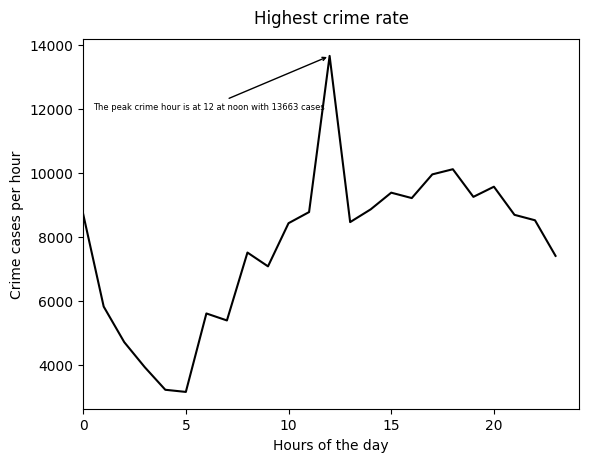

In [38]:
# Visualize the crime rates distribution per hour

fig,ax = plt.subplots()
g = plot_data(ax,sns.lineplot,crimes_hours.index,crimes_hours["crimes_per_grouped"],
             color= "black",
             xlabel= "Hours of the day",
             ylabel= "Crime cases per hour", 
             title = "Highest crime rate")
plt.annotate("The peak crime hour is at " f"{peak_crime_hour}" " at noon with " f"{max_crime}" " cases",
             xy= (peak_crime_hour,max_crime),
             xytext= (0.5,12000), 
             fontsize= 6, 
             arrowprops= {"arrowstyle":"->","color":"black"})
plt.show()

In [39]:
# Question 2 - show the area with the highest crime rate at night

# Subset a dataframe for night hours
crimes_nights = crimes[(crimes["hours"] >= 22) | (crimes["hours"] < 4)][["DR_NO","AREA NAME","hours"]]

# Calculate the area with the highest nightly crime 
crimes_areas,(max_crime_rate_area,max_area) = grouping(crimes_nights,"AREA NAME","DR_NO","count")
crimes_areas = crimes_areas.sort_values("crimes_per_grouped", ascending = False)
peak_night_crime_location = max_area
max_night_crimes = max_crime_rate_area

print("The area with the highest crime during night hours is " +str(peak_night_crime_location) + " with "+ str(max_night_crimes) + " cases.")

The area with the highest crime during night hours is Central with 3312 cases.


/var/folders/s1/9gzjgy453p19bg4rxsy8lvvw0000gn/T/ipykernel_39200/1035679743.py:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  plot_func(x= x, y= y, ax= ax, color= color, **kwargs)


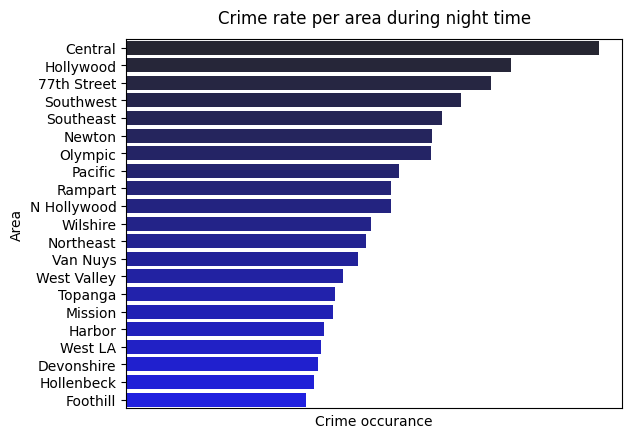

In [40]:
# Visualize the crime rates distribution per area at night
fig,ax = plt.subplots()
plot_data(ax, 
          sns.barplot, 
          crimes_areas["crimes_per_grouped"], 
          crimes_areas.index, 
          color = "blue", 
          xlabel= "Crime occurance", 
          ylabel= "Area",
          title= "Crime rate per area during night time", 
          hue= crimes_areas.index, 
          legend= False,
          errorbar= None)

plt.xticks([])
plt.show()

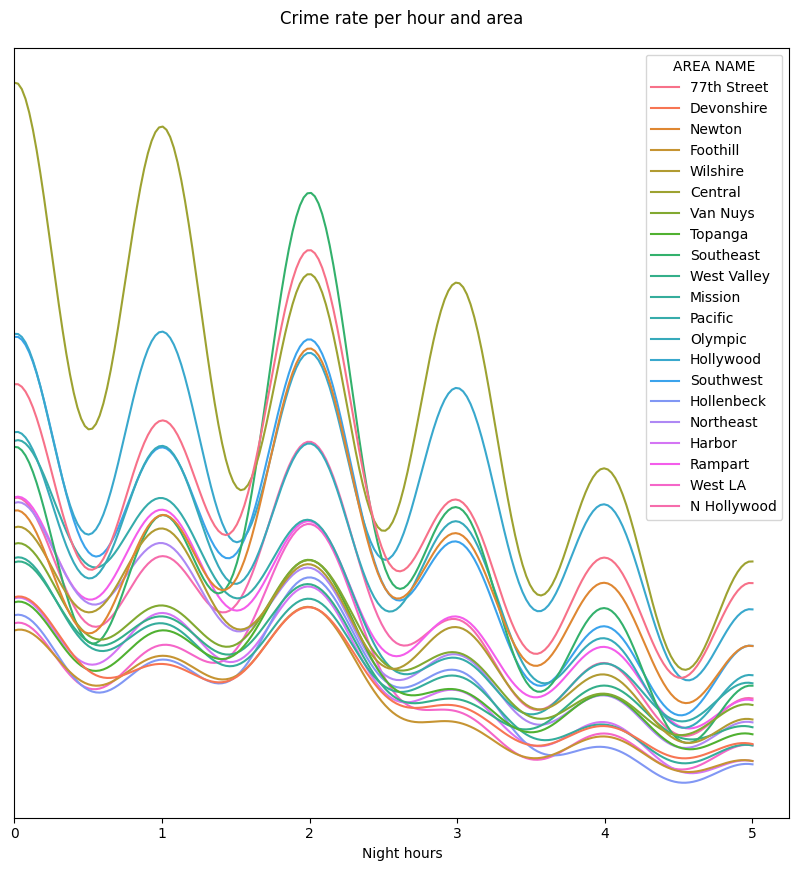

In [41]:
# Extra -  visualise crime distribution per hour and area
# Prepare a column for KDE visual to also show distribution per hour

hour_map = {22: 0, 23: 1, 0: 2, 1: 3, 2: 4}

crimes_nights["hours_KDE"] = crimes_nights["hours"].map(hour_map).fillna(5).astype(int)

fig,ax = plt.subplots(figsize = (10,10))
plot_data(ax,
          sns.kdeplot,
          crimes_nights["hours_KDE"],
          None,
          color= "blue",
          xlabel= "Night hours",
          ylabel= "Crime occurance",
          title= "Crime rate per hour and area",
          hue= crimes_nights["AREA NAME"],
          cut= 0)

plt.gca().get_yaxis().set_visible(False)
plt.show()

In [42]:
# QUESTION 3
# Subset a data frame with ages and crimes
crimes_ages = crimes[["DR_NO","Vict Age"]]

# Add a column with the age groups
age_brackets = {(0,17):"0-17",(18,25):"18-25",(26,34):"26-34",(35,44):"35-44",(45,54):"45-54",(55,64):"55-64",(65,crimes_ages["Vict Age"].max()):"65+"}

# Match an age to the age group
def map_age_group(age):
    for (start, end), group in age_brackets.items():
        if start <= age <= end:
            return group
    return None 

# Apply the function to the ages column
crimes_ages = crimes_ages.copy()
crimes_ages.loc[:,"age groups"] = crimes_ages["Vict Age"].map(map_age_group)

# Create a python series
victim_ages = crimes_ages["age groups"].value_counts()
print(victim_ages)

age groups
26-34    47470
35-44    42157
45-54    28353
18-25    28291
55-64    20169
65+      14747
0-17      4528
Name: count, dtype: int64


/var/folders/s1/9gzjgy453p19bg4rxsy8lvvw0000gn/T/ipykernel_39200/1035679743.py:5: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  plot_func(x= x, y= y, ax= ax, color= color, **kwargs)


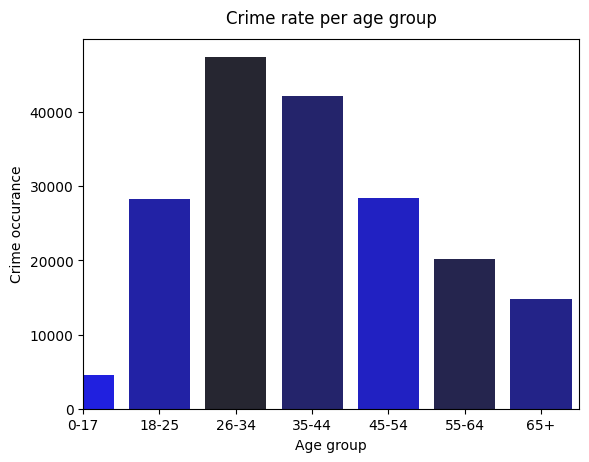

In [43]:
# Visualize the distribution per age group

category_order = ["0-17","18-25","26-34","35-44","45-54","55-64","65+"]

fig,ax = plt.subplots()
plot_data(ax, 
          sns.countplot, 
          crimes_ages["age groups"], 
          None, 
          color= "blue",
          xlabel= "Age group", 
          ylabel= "Crime occurance",
          title= "Crime rate per age group",
          hue= crimes_ages["age groups"], 
          legend= False, 
          order= category_order)

plt.show()

